<a href="https://colab.research.google.com/github/Abdelrahman-Alkhodary/Computer-Vision_with_tensorflow/blob/main/CNN_TF_Malaria_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Normalization, Dense, InputLayer, Conv2D, MaxPool2D, Flatten, Input, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete3DDHG8/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmp0e4x9lbmtfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

In [5]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  dataset_size = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*dataset_size))

  val_test_dataset  = dataset.skip(int(TRAIN_RATIO*dataset_size))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*dataset_size))
  test_dataset = val_test_dataset.skip(int(VAL_RATIO*dataset_size))
  return train_dataset, val_dataset, test_dataset

In [6]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [7]:
len(train_dataset), len(val_dataset), len(test_dataset)

(22046, 2755, 2757)

# **Data Visualization**

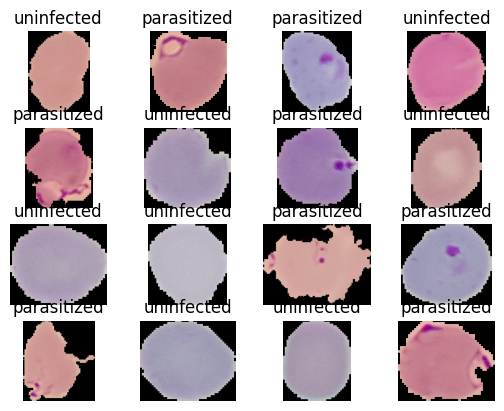

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [9]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  print(image.shape)

(151, 115, 3)
(121, 115, 3)
(157, 136, 3)
(151, 148, 3)
(133, 112, 3)
(109, 118, 3)
(115, 115, 3)
(103, 91, 3)
(118, 142, 3)
(145, 142, 3)
(187, 250, 3)
(136, 154, 3)
(166, 148, 3)
(124, 148, 3)
(136, 115, 3)
(121, 145, 3)


In [10]:
# we will define a function to resize the image of the dataset as images have different sizes
# new image size will be square of 224
IM_SIZE = 224
def resizing_rescaling(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255, label

In [11]:
train_dataset = train_dataset.map(resizing_rescaling)

In [12]:
val_dataset = val_dataset.map(resizing_rescaling)

test_dataset = test_dataset.map(resizing_rescaling)

In [13]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  print(image.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


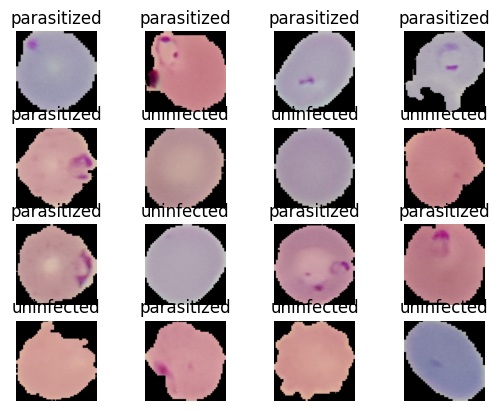

In [14]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [15]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
from keras.src.layers.serialization import activation
from keras.src.engine.training import input_ops
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=BinaryCrossentropy(),
    metrics='accuracy'
)

In [18]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
  8/689 [..............................] - ETA: 15:37 - loss: 0.7631 - accuracy: 0.5391

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

In [ ]:
test_dataset = test_dataset.batch(1)
test_dataset

In [ ]:
model.evaluate(test_dataset)

In [ ]:
model.predict(test_dataset.take(1))

In [ ]:
def label_define(x):
  if x<0.5:
    return str('P')
  else:
    return str('U')

In [ ]:
label_define(model.predict(test_dataset.take(1))[0][0])

In [ ]:
model.predict(test_dataset.take(1))[0][0]

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(label_define(label.numpy()[0])) + ':' + str(label_define(model.predict(image)[0][0])))
  plt.axis('off')
  # plt.show()

In [ ]:
# save the model configuration and the model's weights
model.save('LenetSavedModel')

In [ ]:
lenet_loaded_model = tf.keras.models.load_model('LenetSavedModel')
lenet_loaded_model.summary()

In [ ]:
lenet_loaded_model.evaluate(test_dataset)

In [ ]:
model.save('Lenet.hdf5')

In [ ]:
lenet_loaded_model = tf.keras.models.load_model('Lenet.hdf5')
lenet_loaded_model.summary()

In [ ]:
# save only the model's weights
model.save_weights('weights/lenet_weights')

Saving to Google Drive

In [ ]:
drive.mount('/content/drive/')

In [ ]:
# copy the model to the drive
!cp -r /content/LenetSavedModel/ /content/drive/MyDrive/lenet/

# Functional API

In [19]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3))

x = Conv2D(filters=6, kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, output, name='Feature_Extractor')
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [20]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3))

x = feature_extractor_model(func_input)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

lenet_model = Model(func_input, func_output, name='Lenet_Modle')

lenet_model.summary()

Model: "Lenet_Modle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                

# Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation) -> None:
    super(FeatureExtractor, self).__init__()
    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=2, strides=2)

    self.conv_2 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=2, strides=2)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(6, 3, (1,1), 'valid', 'relu')

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3))

x = feature_sub_classed(func_input)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

lenet_model = Model(func_input, func_output, name='Lenet_Modle')

lenet_model.summary()

In [ ]:
class LenetModel(Model):
  def __init__(self) -> None:
    super(LenetModel, self).__init__()
    self.feature_sub_classed = FeatureExtractor(6, 3, (1,1), 'valid', 'relu')

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation='relu')
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation='relu')
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation='sigmoid')

  def call(self, x):
    print(x.shape)
    x = self.feature_sub_classed(x)
    print(x.shape)
    x = self.flatten(x)
    print(x.shape)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x


model_sub_classed = LenetModel()
model_sub_classed(tf.zeros([1,244,244,3]))
model_sub_classed.summary()

In [21]:
metrics = [TruePositives(name='tp'), BinaryAccuracy(name='accuracy'), FalsePositives(name='fp'), FalseNegatives(name='fn'), TrueNegatives(name='tn'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [22]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                          loss=BinaryCrossentropy(),
                          metrics=metrics)

In [ ]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
 14/689 [..............................] - ETA: 26:49 - loss: 0.5649 - tp: 175.0000 - accuracy: 0.7121 - fp: 65.0000 - fn: 64.0000 - tn: 144.0000 - precision: 0.7292 - recall: 0.7322 - auc: 0.7783